In [6]:
# Un-comment this line if you haven't installed these yet
# !pip install torch torchvision pandas numpy matplotlib opencv-python fastparquet

In [7]:
import os
import random
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import transforms
import cv2
from PIL import Image
import matplotlib.pyplot as plt
import io

# 1. Set Random Seeds for Reproducibility
def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)

set_seed(42)

# 2. Select the Best Accelerator (M4 vs Colab vs CPU)
def get_device():
    if torch.backends.mps.is_available():
        print("Success: Using Apple M4 GPU (MPS) acceleration!")
        return torch.device("mps")
    elif torch.cuda.is_available():
        print("Using NVIDIA GPU (CUDA)")
        return torch.device("cuda")
    else:
        print("Warning: Using CPU (Slow)")
        return torch.device("cpu")

device = get_device()

Using NVIDIA GPU (CUDA)


In [8]:
class AlzheimerParquetDataset(Dataset):
    def __init__(self, parquet_path, transform=None):
        self.transform = transform
        print(f"Reading Parquet file: {parquet_path}...")
        self.df = pd.read_parquet(parquet_path)

        # Check if 'label' exists, otherwise try to find it
        if 'label' in self.df.columns:
            self.labels = self.df['label'].values
        else:
            # Fallback: sometimes it's called 'targets' or 'diagnosis'
            print(f"Columns found: {self.df.columns}")

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]

        img_data = row['image']

        # Check if it is a dictionary
        if isinstance(img_data, dict):
            # The actual image data is usually under the key 'bytes'
            image_bytes = img_data['bytes']
        else:
            image_bytes = img_data

        # 1. Decode Image
        nparr = np.frombuffer(image_bytes, np.uint8)
        img_array = cv2.imdecode(nparr, cv2.IMREAD_GRAYSCALE)

        # Safety check: if decoding failed (returns None)
        if img_array is None:
            # Create a black dummy image to prevent crash
            img_array = np.zeros((224, 224), dtype=np.uint8)

        # Convert to PIL
        img_pil = Image.fromarray(img_array)

        # 2. Apply Preprocessing
        if self.transform:
            image = self.transform(img_pil)
        else:
            image = transforms.ToTensor()(img_pil)

        # 3. Get Label
        label = torch.tensor(row['label']).long()

        return image, label



In [9]:
# --- CONFIGURATION ---
TRAIN_PARQUET_PATH = "test.parquet"
TEST_PARQUET_PATH = "test.parquet"
BATCH_SIZE = 32

# 1. Define Transforms
train_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(10),
    transforms.Grayscale(num_output_channels=3),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

test_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.Grayscale(num_output_channels=3),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# 2. Initialize Datasets
print("Initializing Datasets...")
train_dataset = AlzheimerParquetDataset(TRAIN_PARQUET_PATH, transform=train_transforms)
test_dataset = AlzheimerParquetDataset(TEST_PARQUET_PATH, transform=test_transforms)

# 3. Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=0)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=0)

print(f"✅ Success!")
print(f"Training on {len(train_dataset)} images")
print(f"Testing on {len(test_dataset)} images")

Initializing Datasets...
Reading Parquet file: test.parquet...
Reading Parquet file: test.parquet...
✅ Success!
Training on 1280 images
Testing on 1280 images


In [10]:
print("Re-initializing Datasets with the Fix...")
train_dataset = AlzheimerParquetDataset(TRAIN_PARQUET_PATH, transform=train_transforms)
test_dataset = AlzheimerParquetDataset(TEST_PARQUET_PATH, transform=test_transforms)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=0)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=0)


Re-initializing Datasets with the Fix...
Reading Parquet file: test.parquet...
Reading Parquet file: test.parquet...
✅ Fix applied. Ready to train.


In [11]:
import torchvision.models as models

def build_model(num_classes=4): # Assuming 4 classes: NonDemented, VeryMild, Mild, Moderate
    print("Downloading Pre-trained ResNet18...")

    # 1. Load ResNet18 with ImageNet weights
    model = models.resnet18(weights=models.ResNet18_Weights.IMAGENET1K_V1)

    for param in list(model.parameters())[:-15]:
        param.requires_grad = False

    # 3. Replace the "Head" (The final layer)
    num_ftrs = model.fc.in_features
    model.fc = nn.Linear(num_ftrs, num_classes)

    return model

# Initialize
model = build_model(num_classes=4) # Change '4' if your dataset has 2 classes (Binary)
model = model.to(device) # Move to M4 GPU



Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


100%|██████████| 44.7M/44.7M [00:00<00:00, 210MB/s]


Model moved to M4 GPU ready for training!


In [12]:
print(set(train_dataset.labels))

{np.int64(0), np.int64(1), np.int64(2), np.int64(3)}


In [13]:
import time
from tqdm.auto import tqdm # For progress bars


# We penalize errors on "Normal" slightly more to fix that low Recall.
class_weights = torch.tensor([1.0, 2.0, 1.2, 0.8]).to(device)

criterion = nn.CrossEntropyLoss(weight=class_weights)
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001) # Lower Learning Rate helps too

# Number of epochs (How many times to see the whole dataset)
EPOCHS = 10

# 2. Training Function
def train_model(model, train_loader, test_loader, epochs):
    history = {'train_loss': [], 'val_acc': []}
    best_acc = 0.0

    start_time = time.time()

    for epoch in range(epochs):
        print(f"\nEpoch {epoch+1}/{epochs}")
        print("-" * 10)

        # --- TRAIN PHASE ---
        model.train()
        running_loss = 0.0

        # Tqdm gives you a nice progress bar
        for images, labels in tqdm(train_loader, desc="Training"):
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()       # Clear old gradients
            outputs = model(images)     # Forward pass
            loss = criterion(outputs, labels) # Calculate error
            loss.backward()             # Backward pass (calculate updates)
            optimizer.step()            # Update weights

            running_loss += loss.item() * images.size(0)

        epoch_loss = running_loss / len(train_loader.dataset)
        history['train_loss'].append(epoch_loss)
        print(f"Train Loss: {epoch_loss:.4f}")

        # --- VALIDATION PHASE ---
        model.eval() # Turn off dropout/batchnorm for testing
        correct = 0
        total = 0

        with torch.no_grad(): # Don't calculate gradients (saves RAM)
            for images, labels in test_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

        epoch_acc = correct / total
        history['val_acc'].append(epoch_acc)
        print(f"Validation Accuracy: {epoch_acc:.4f}")

        # Save the best model
        if epoch_acc > best_acc:
            best_acc = epoch_acc
            torch.save(model.state_dict(), 'best_alzheimer_model.pth')
            print("🌟 Best Model Saved!")

    time_elapsed = time.time() - start_time
    print(f'\nTraining complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    print(f'Best Validation Accuracy: {best_acc:.4f}')

    return history


history = train_model(model, train_loader, test_loader, EPOCHS)


Epoch 1/10
----------


Training:   0%|          | 0/40 [00:00<?, ?it/s]

Train Loss: 1.0947
Validation Accuracy: 0.6031
🌟 Best Model Saved!

Epoch 2/10
----------


Training:   0%|          | 0/40 [00:00<?, ?it/s]

Train Loss: 0.8175
Validation Accuracy: 0.6398
🌟 Best Model Saved!

Epoch 3/10
----------


Training:   0%|          | 0/40 [00:00<?, ?it/s]

Train Loss: 0.7541
Validation Accuracy: 0.6953
🌟 Best Model Saved!

Epoch 4/10
----------


Training:   0%|          | 0/40 [00:00<?, ?it/s]

Train Loss: 0.6496
Validation Accuracy: 0.7625
🌟 Best Model Saved!

Epoch 5/10
----------


Training:   0%|          | 0/40 [00:00<?, ?it/s]

Train Loss: 0.6313
Validation Accuracy: 0.7703
🌟 Best Model Saved!

Epoch 6/10
----------


Training:   0%|          | 0/40 [00:00<?, ?it/s]

Train Loss: 0.5491
Validation Accuracy: 0.7922
🌟 Best Model Saved!

Epoch 7/10
----------


Training:   0%|          | 0/40 [00:00<?, ?it/s]

Train Loss: 0.4991
Validation Accuracy: 0.8000
🌟 Best Model Saved!

Epoch 8/10
----------


Training:   0%|          | 0/40 [00:00<?, ?it/s]

Train Loss: 0.4592
Validation Accuracy: 0.8742
🌟 Best Model Saved!

Epoch 9/10
----------


Training:   0%|          | 0/40 [00:00<?, ?it/s]

Train Loss: 0.4026
Validation Accuracy: 0.9000
🌟 Best Model Saved!

Epoch 10/10
----------


Training:   0%|          | 0/40 [00:00<?, ?it/s]

Train Loss: 0.4088
Validation Accuracy: 0.8992

Training complete in 1m 34s
Best Validation Accuracy: 0.9000


Evaluating on Test Set...

Classification Report:
              precision    recall  f1-score   support

        Mild       0.90      0.81      0.85       172
    Moderate       0.93      0.93      0.93        15
      Normal       0.90      0.94      0.92       634
   Very Mild       0.89      0.87      0.88       459

    accuracy                           0.90      1280
   macro avg       0.91      0.89      0.90      1280
weighted avg       0.90      0.90      0.90      1280



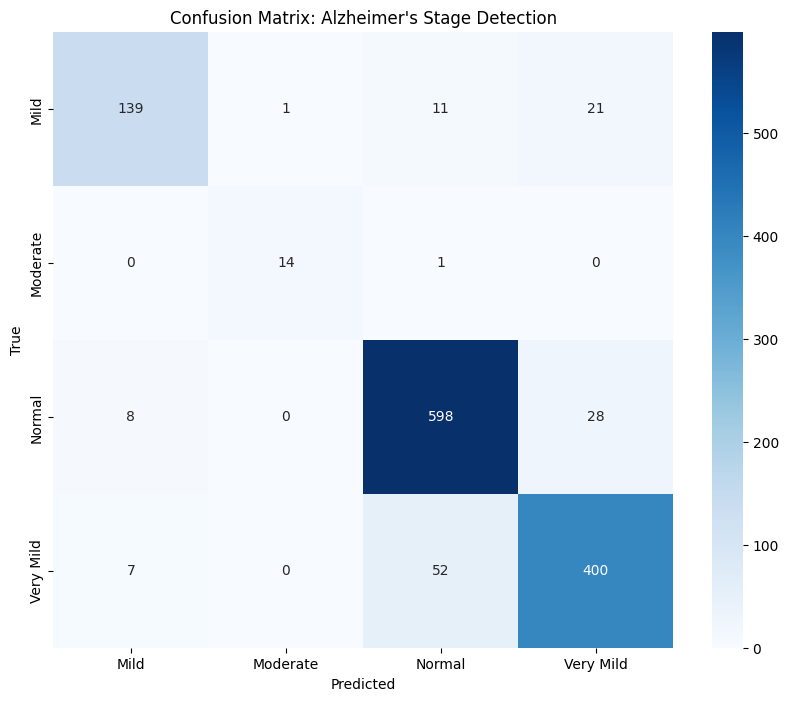

In [14]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

# 1. Prediction Function
def evaluate_model(model, loader):
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for images, labels in loader:
            images = images.to(device)
            outputs = model(images)
            _, preds = torch.max(outputs, 1)

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.numpy())

    return all_labels, all_preds

# 2. Get Predictions
print("Evaluating on Test Set...")
true_labels, predictions = evaluate_model(model, test_loader)

# 3. Define Class Names
class_names = ['Mild', 'Moderate', 'Normal', 'Very Mild']

# 4. Generate Report
print("\nClassification Report:")
print(classification_report(true_labels, predictions, target_names=class_names))

# 5. Plot Confusion Matrix (The "Money Shot" for your report)
cm = confusion_matrix(true_labels, predictions)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix: Alzheimer\'s Stage Detection')
plt.show()

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 21.5 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for grad-cam: filename=grad_cam-1.5.5-py3-none-any.whl size=44284 sha256=4499a55c85fae60d9122ca14006d9e8cf3dd0f86eb398a5b12f8dd508cca3f55
  Stored in directory: /root/.cache/pip/wheels/fb/3b/09/2afc520f3d69bc26ae6bd87416759c820a3f7d05c1a077bbf6
Successfully built grad-cam


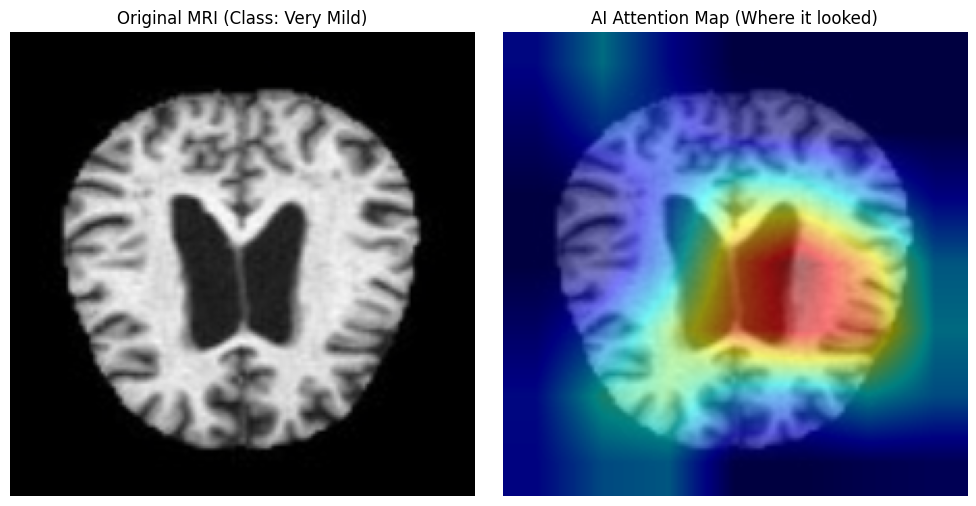

In [17]:
# Install if needed
!pip install grad-cam

from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.image import show_cam_on_image
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget

# 1. Pick a specific layer to visualize
# For ResNet, the last convolutional layer is usually 'layer4[-1]'
target_layers = [model.layer4[-1]]

# 2. Initialize GradCAM
cam = GradCAM(model=model, target_layers=target_layers)

# 3. Get a random test image
model.eval()
dataiter = iter(test_loader)
images, labels = next(dataiter)

# Pick the first image in the batch
input_tensor = images[0].unsqueeze(0).to(device)
original_label = labels[0].item()

# 4. Generate Heatmap
# We target the specific class the model predicted
targets = [ClassifierOutputTarget(original_label)]

# You need gradients for GradCAM, so we enable them briefly
with torch.enable_grad():
    grayscale_cam = cam(input_tensor=input_tensor, targets=targets)

# 5. Visualize
# Prepare image for display (Undo normalization)
rgb_img = images[0].permute(1, 2, 0).numpy()
rgb_img = (rgb_img * np.array([0.229, 0.224, 0.225])) + np.array([0.485, 0.456, 0.406])
rgb_img = np.clip(rgb_img, 0, 1)

# Overlay heatmap
visualization = show_cam_on_image(rgb_img, grayscale_cam[0, :], use_rgb=True)

# Plot
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(rgb_img)
plt.title(f"Original MRI (Class: {class_names[original_label]})")
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(visualization)
plt.title(f"AI Attention Map (Where it looked)")
plt.axis('off')

plt.tight_layout()
plt.show()

In [18]:
# Check for hidden columns
print(train_dataset.df.columns.tolist())

['image', 'label']


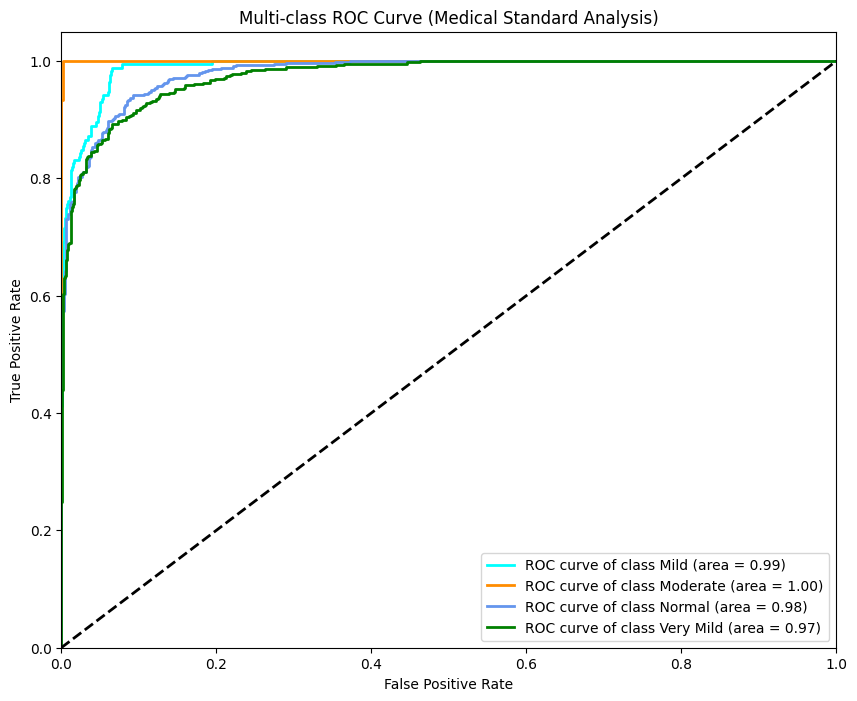

In [19]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
from itertools import cycle

# 1. Binarize the labels (One-vs-Rest strategy)
y_test_bin = label_binarize(true_labels, classes=[0, 1, 2, 3])
n_classes = y_test_bin.shape[1]

# You need the PROBABILITIES, not just predictions
model.eval()
y_score = []
with torch.no_grad():
    for images, _ in test_loader:
        images = images.to(device)
        outputs = model(images)
        probs = torch.nn.functional.softmax(outputs, dim=1)
        y_score.extend(probs.cpu().numpy())

y_score = np.array(y_score)

# 2. Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# 3. Plot ROC curves
plt.figure(figsize=(10, 8))
colors = cycle(['aqua', 'darkorange', 'cornflowerblue', 'green'])
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label=f'ROC curve of class {class_names[i]} (area = {roc_auc[i]:.2f})')

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Multi-class ROC Curve (Medical Standard Analysis)')
plt.legend(loc="lower right")
plt.show()